In [117]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.measure import centroid
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

from myUtils import *

RES = 320

In [118]:
model = torch.load(f'./best_model.pth').eval().cuda()

In [119]:
fp_in = './test_input2.mp4'

vidcap = cv2.VideoCapture(fp_in)
frameCount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frameRate = int(vidcap.get(cv2.CAP_PROP_FPS))
video = torch.empty((frameCount, 3, RES, RES))

success = True
i = 0
while success:
    success, frame = vidcap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (RES, RES))
        frame = transforms.ToTensor()(frame)
        video[i] = frame
        i += 1

In [120]:
frameCount

275

In [121]:
video.shape

torch.Size([275, 3, 320, 320])

In [122]:
dataloader = DataLoader(video, batch_size=4)

In [123]:
mask = torch.empty((frameCount, 2, RES, RES), dtype=torch.float64)
filledTo = 0
for batch in dataloader:
    batch = batch.cuda()
    size = batch.shape[0]
    pred = model(batch)

    # add pred to mask
    mask[filledTo:(filledTo + size)] = pred.cpu().detach()
    filledTo += size

del batch, pred, model
torch.cuda.empty_cache()

mask = mask.numpy()

/root/workspace/tracking/venv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [124]:
mask.shape

(275, 2, 320, 320)

In [125]:
center = np.empty((frameCount, 2, 2))
area = np.empty((frameCount, 2))
idx = 0
for frame in mask:
    area[idx] = frame.sum(axis=(1, 2))
    
    center[idx, 0, :] = centroid(frame[0])[::-1]
    center[idx, 1, :] = centroid(frame[1])[::-1]

    idx += 1

center = center/RES
center[:, :, 1] = 1 - center[:, :, 1]

diff = np.zeros((frameCount, 2, 2))
diff[:-2] = np.abs(center[0:-2, :, :] - center[1:-1, :, :])

Remove abnormally small segmentations or points that make a large jump

In [126]:
np.percentile(diff, 99.9999)

0.10885303657823087

In [127]:
np.percentile(area, [1])

array([2517.38919398])

In [128]:
pct = 100

In [129]:
center[area < pct] = np.nan
center[diff > 0.1] = np.nan

In [130]:
center.shape

(275, 2, 2)

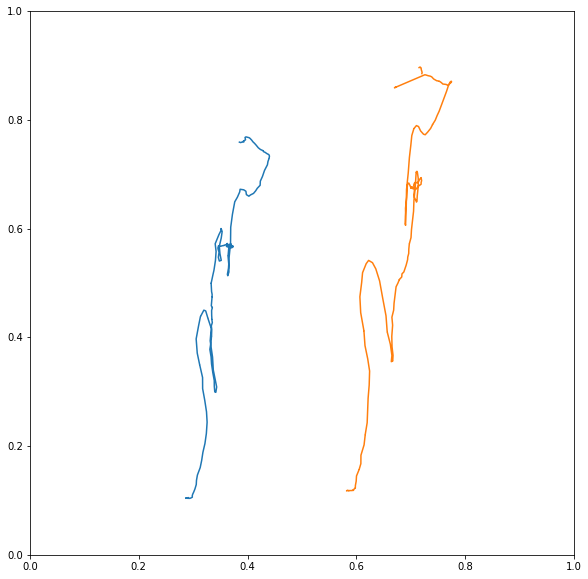

In [131]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

plt.plot(center[:, :, 0], center[:, :, 1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [132]:
gray = video.mean(axis=1).reshape(frameCount, 1, RES, RES)
combined = np.concatenate((gray, mask), axis=1)*255
combined = combined.astype(np.uint8)

combined = np.swapaxes(combined, 1, -1)
combined = np.swapaxes(combined, 1, 2)
combined.shape

(275, 320, 320, 3)

In [133]:
imgs = [Image.fromarray(img) for img in combined]

In [134]:
imgs[0].save("test_out.gif", save_all=True, append_images=imgs[1:], duration=1000/frameRate, loop=0)

![test2](./test_out.gif)